# CS/ECE/ISyE 524 - Spring 2017 - Homework 6 - Solutions
### Prepared by: Laurent Lessard

## 1. Huber loss

In statistics, we frequently encounter data sets containing  _outliers_, which are bad data points arising from experimental error or abnormally high noise. Consider for example the following data set consisting of 15 pairs $(x,y)$.

| |
|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|
|$x$ | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 | 11 | 12 | 13 | 14 | 15
|$y$ | 6.31 | 3.78 | 24 | 1.71 | 2.99 | 4.53 | 2.11 | 3.88 | 4.67 | 4.25 | 2.06 | 23 | 1.58 | 2.17 | 0.02

The $y$ values corresponding to $x=3$ and $x=12$ are outliers because they are far outside the expected range of values for the experiment.

**(a)** Compute the best linear fit to the data using an $\ell_2$ cost (least squares). In other words, we are looking for the $a$ and $b$ that minimize the expression:
$$
\text{$\ell_2$ cost:}\qquad 
\sum_{i=1}^{15} (y_i - a x_i - b)^2
$$
Repeat the linear fit computation but this time exclude the outliers from your data set. On a single plot, show the data points and both linear fits. Explain the difference between both fits.

**(b)** It's not always practical to remove outliers from the data manually, so we'll investigate ways of automatically dealing with outliers by changing our cost function. Find the best linear fit again (including the outliers), but this time use the $\ell_1$ cost function:
$$
\text{$\ell_1$ cost:}\qquad 
\sum_{i=1}^{15} \left|\,y_i - a x_i - b\,\right|
$$
Include a plot containing the data and the best $\ell_1$ linear fit. Does the $\ell_1$ cost handle outliers better or worse than least squares? Explain why.
%You should notice that the $\ell_1$ cost handles outliers better than least squares but there is still a bias; there are many more points below the line than above.

**(c)** Another approach is to use an $\ell_2$ penalty for points that are close to the line but an $\ell_1$ penalty for points that are far away. Specifically, we'll use something called the _Huber loss_, defined as:
$$
\phi(x) = \begin{cases}
x^2 & \text{if } -M\le x \le M \\
2M|x|-M^2 & \text{otherwise}
\end{cases}
$$
Here, $M$ is a parameter that determines where the quadratic function transitions to a linear function. The formula above is simple, but not in a form that is useful for us. As it turns out, we can evaluate the Huber loss function at any point $x$ by solving the following convex QP instead:
$$
\phi(x) = \left\{ \begin{aligned}
\underset{v,w}{\text{minimize}}\quad & w^2 + 2 M v \\
\text{subject to:}\quad & |x| \le w + v \\
&v \ge 0,\,\, w \le M
\end{aligned}\right\}
$$
Verify this fact by solving the above QP (with $M=1$) for many values of $x$ in the interval $-3 \le x \le 3$ and reproducing the plot above. Finally, find the best linear fit to our data  using a Huber loss with $M=1$ and produce a plot showing your fit. The cost function is:
$$
\text{Huber loss:}\qquad 
\sum_{i=1}^{15} \phi(\,y_i - a x_i - b)
$$

In [34]:
using JuMP, Gurobi

y = [6.31, 3.78, 24, 1.71, 2.99, 4.53, 2.11, 3.88, 4.67, 4.25, 2.06, 23, 1.58, 2.17, 0.02]
x = 1:15

# PART A code

# find the least-squares fit using ALL the data points
c = 1:15
m = Model(solver=GurobiSolver(OutputFlag=0))
@variable(m, a)
@variable(m, b)
@expression(m, t, sum((y[i] - a*x[i] - b)^2 for i in c ));
@objective(m, Min, t)
status = solve(m)
a1,b1 = getvalue(a),getvalue(b)
println("a1=",a1,",  b1=",b1)

# find the least squares fit REMOVING OUTLIERS
c = collect([1:2; 4:11; 13:15])
m = Model(solver=GurobiSolver(OutputFlag=0))
@variable(m, a)
@variable(m, b)
@expression(m, t, sum((y[i] - a*x[i] - b)^2 for i in c ));
@objective(m, Min, t)
status = solve(m)
a2,b2 = getvalue(a),getvalue(b)
println("a2=",a2,",  b2=",b2)

# PART B code

# find the L1 fit using ALL the data points
c = 1:15
m = Model(solver=GurobiSolver(OutputFlag=0))
@variable(m, a)
@variable(m, b)
@variable(m, t[1:15] >= 0)
@constraint(m, flow1[i in c], y[i] - a*x[i] - b <=  t[i])
@constraint(m, flow2[i in c], y[i] - a*x[i] - b >= -t[i])
@objective(m, Min, sum(t))
status = solve(m)
a3,b3 = getvalue(a),getvalue(b)
println("a3=",a3,",  b3=",b3)

# find the L1 fit REMOVING OUTLIERS
c = collect([1:2; 4:11; 13:15])
m = Model(solver=GurobiSolver(OutputFlag=0))
@variable(m, a)
@variable(m, b)
@variable(m, t[1:15] >= 0)
@constraint(m, flow3[i in c], y[i] - a*x[i] - b <=  t[i])
@constraint(m, flow4[i in c], y[i] - a*x[i] - b >= -t[i])
@objective(m, Min, sum(t))
status = solve(m)
a4,b4 = getvalue(a),getvalue(b)
println("a4=",a4,",  b4=",b4)
;

a1=-0.29078571428565925,  b1=8.130285714283605
a2=-0.23648422408233877,  b2=4.9916033483557305
a3=-0.35599999999999987,  b3=6.6659999999999995
a4=-0.19111111111111145,  b4=4.162222222222223


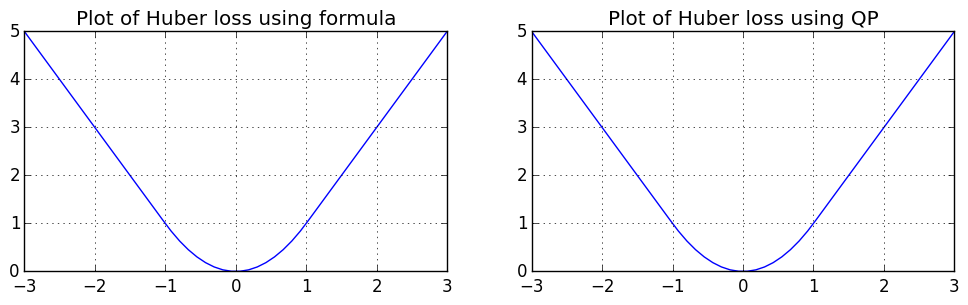

In [40]:
# PART C (first part)

M = 1
hx = linspace(-3,3,50)

# compute Huber loss using formula
hy1 = zeros(size(hx))
for (i,xx) in enumerate(hx)
    if abs(xx) <= M
        hy1[i] = xx^2
    else
        hy1[i] = 2*M*abs(xx) - M^2
    end
end

# compute Huber loss using QP
hy2 = zeros(size(hx))
for (i,xx) in enumerate(hx)
    m = Model(solver=GurobiSolver(OutputFlag=0))
    @variable(m, v >= 0)
    @variable(m, w <= M)
    @constraint(m, abs(xx) <= v + w)
    @objective(m, Min, w^2 + 2*M*v)
    solve(m)
    hy2[i] = getobjectivevalue(m)
end

using PyPlot
figure(figsize = (12,3))

subplot(1,2,1)
plot(hx,hy1)
axis([-3,3,0,5])
grid("on")
title("Plot of Huber loss using formula")

subplot(1,2,2)
plot(hx,hy2)
axis([-3,3,0,5])
grid("on")
title("Plot of Huber loss using QP")
;

In [42]:
# PART C code

# find the Huber fit using ALL the data points
c = 1:15
m = Model(solver=GurobiSolver(OutputFlag=0))
@variable(m, a)
@variable(m, b)
@variable(m, v[1:15] >= 0)
@variable(m, w[1:15] <= M)
@constraint(m, flow5[i in c], y[i] - a*x[i] - b <=  w[i] + v[i])
@constraint(m, flow6[i in c], y[i] - a*x[i] - b >= -w[i] - v[i])
@objective(m, Min, sum(w.^2) + 2*M*sum(v))
status = solve(m)
a5,b5 = getvalue(a),getvalue(b)
println("a5=",a5,",  b5=",b5)

# find the Huber fit REMOVING OUTLIERS
c = collect([1:2; 4:11; 13:15])
m = Model(solver=GurobiSolver(OutputFlag=0))
@variable(m, a)
@variable(m, b)
@variable(m, v[1:15] >= 0)
@variable(m, w[1:15] <= M)
@constraint(m, flow7[i in c], y[i] - a*x[i] - b <=  w[i] + v[i])
@constraint(m, flow8[i in c], y[i] - a*x[i] - b >= -w[i] - v[i])
@objective(m, Min, sum(w.^2) + 2*M*sum(v))
status = solve(m)
a6,b6 = getvalue(a),getvalue(b)
println("a6=",a6,",  b6=",b6)
;

a5=-0.2811079944792563,  b5=5.738120618207088
a6=-0.243009708730397,  b6=5.046796116456781


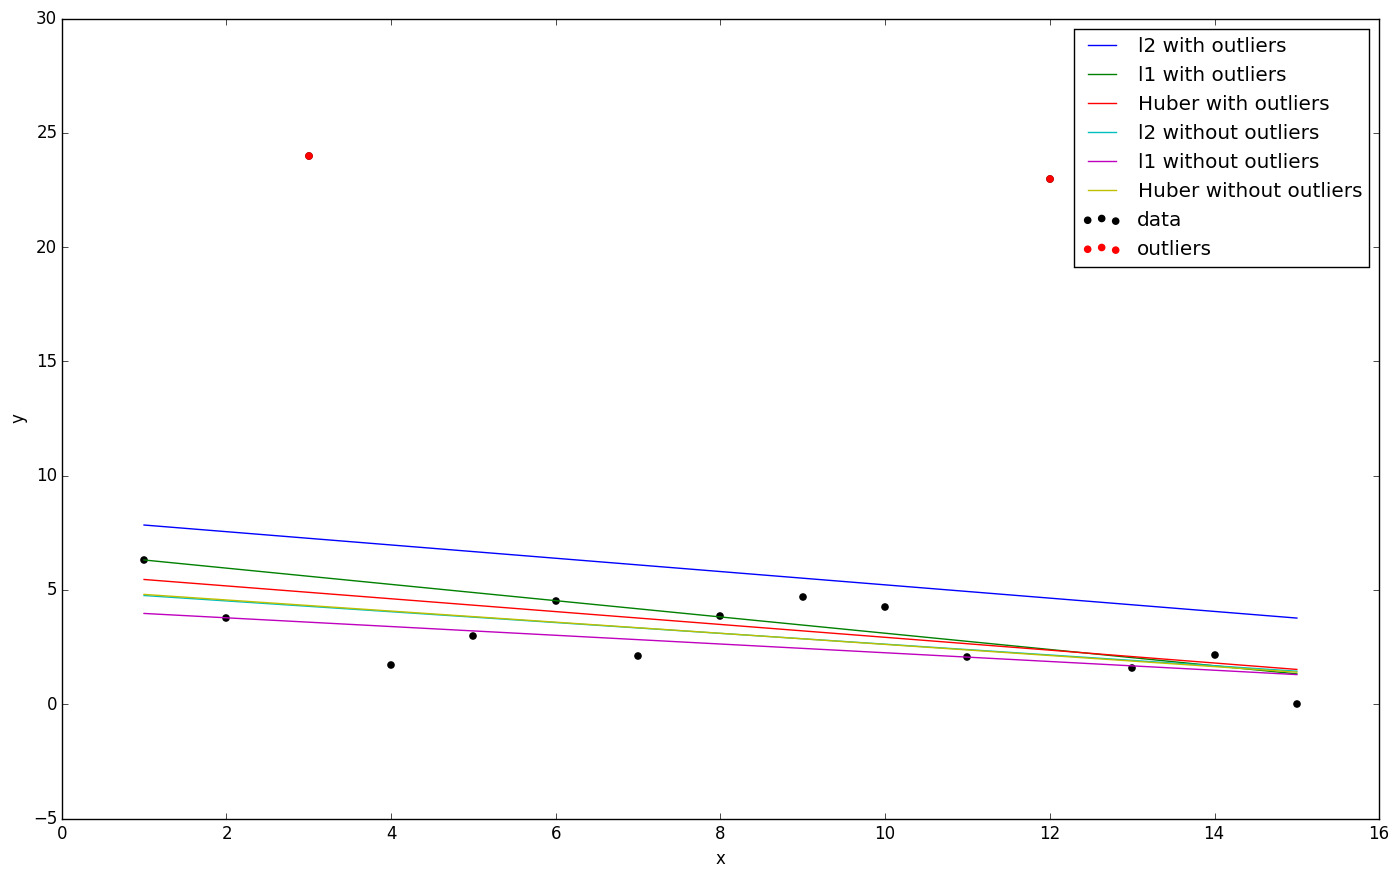

In [47]:
# Make all the plots

using PyPlot
figure(figsize = (17,10))
scatter(x,y,label="data",color = "black")
scatter([x[3],x[12]],[y[3],y[12]],label="outliers",color = "red") # outliers
plot(x, a1*x + b1,label="l2 with outliers")
plot(x, a3*x + b3,label="l1 with outliers")
plot(x, a5*x + b5,label="Huber with outliers")
plot(x, a2*x + b2,label="l2 without outliers")
plot(x, a4*x + b4,label="l1 without outliers")
plot(x, a6*x + b6,label="Huber without outliers")
legend(loc ="best")
ylabel("y")
xlabel("x")
;

## 2. Hyperbolic program

In this problem, we start with a problem that doesn't appear to be convex and show that it is in fact convex by converting it into an SOCP.

**a)** Recall from class that for any $w \in \mathbb{R}^n$ and $x,y \in \mathbb{R}$, the following constraints are equivalent:
$$
w^T w \le xy,\quad x\ge 0,\quad y\ge 0
\qquad \iff \qquad
\left\|\begin{bmatrix}2w \\ x-y\end{bmatrix}\right\| \le x + y
$$
Suppose we have an optimization problem with variables $t \ge 0$ and $x\in\mathbb{R}^n$. Express the constraint: $t (a^T x + b) \ge 1$ as a second-order cone constraint. Specifically, write the constraint in the form $\|Ax+b\| \le c^T x + d$. What are $A,b,c,d,x$?

**b)** Consider the following _hyperbolic_ optimization problem (note the nonlinear objective):
\begin{align*}
\underset{x}{\text{minimize}} \qquad & \sum_{i=1}^p 1/(a_i^T x + b_i) \\
\text{subject to}\qquad & a_i^T x + b_i > 0, \qquad i=1,\dots,p \\
& c_j^T x + d_j \ge 0, \qquad j = 1,\dots,q
\end{align*}
Write this optimization problem as an SOCP. _Hint:_ the first part of this problem is very relevant!

**Solution to part a):** Key observation here is that the constraints are equivalent in general; regardless of whether the symbols involved are variables, parameters, or constants! So we can make the substitution: $t \mapsto x$, and $y\mapsto a^Tx+b$, and $w\mapsto 1$. We get the equivalence:
$$
1 \le t(a^Tx+b),\quad t\ge 0,\quad a^Tx+b\ge 0
\qquad \iff \qquad
\left\|\begin{bmatrix}2 \\ t-a^Tx-b\end{bmatrix}\right\| \le a^Tx+b+t
$$
Note that the constraint we added $a^Tx+b\ge 0$ wasn't explicitly specified, but since we know that $1 \le t(a^Tx+b)$ and $t \ge 0$, it must be the case that $a^Tx+b\ge 0$. In fact, we even have $a^Tx+b>0$.

The norm constraint we have on the right side can be expressed in standard SOC form as follows:
$$
\left\|\begin{bmatrix}2 \\ t-a^Tx-b\end{bmatrix}\right\| \le a^Tx+b+t
\qquad\iff\qquad
\left\|\begin{bmatrix}0 & 0 \\ -a^T & 1\end{bmatrix}\begin{bmatrix}x \\ t\end{bmatrix}+\begin{bmatrix}2 \\ -b\end{bmatrix}\right\| \le \begin{bmatrix}a^T & 1\end{bmatrix}\begin{bmatrix}x\\t\end{bmatrix}+b
$$

**Solution to part b):** We'll use the epigraph trick and introduce the variables $t_1,\dots,t_p$ that will correspond to each of the terms in the objective. We then have the equivalent problem:
\begin{align*}
\underset{x,t}{\text{minimize}} \qquad & \sum_{i=1}^p t_i \\
\text{subject to}\qquad & a_i^T x + b_i > 0, \qquad i=1,\dots,p \\
& 1/(a_i^T x + b_i) \le t_i,\qquad i=1,\dots,p\\
& c_j^T x + d_j \ge 0, \qquad j = 1,\dots,q
\end{align*}
The first two constraints imply that $1 \le t(a^Tx+b)$ and $t\ge 0$ and $a^Tx+b\ge 0$. Therefore, we can replace them by their SOC constraints from part a). The result is the SOCP:
\begin{align*}
\underset{x,t}{\text{minimize}} \qquad & \sum_{i=1}^p t_i \\
\text{subject to}\qquad & \left\|\begin{bmatrix}2 \\ t_i-a_i^Tx-b_i\end{bmatrix}\right\| \le a^Tx+b_i+t_i, \qquad i=1,\dots,p \\
& c_j^T x + d_j \ge 0, \qquad j = 1,\dots,q
\end{align*}

## 3. Heat pipe design

A heated fluid at temperature $T$ (degrees above ambient temperature) flows in a pipe with fixed length and circular cross section with radius $r$. A layer of insulation, with thickness $w$, surrounds the pipe to reduce heat loss through the pipe walls ($w$ is much smaller than $r$). The design variables in this problem are $T$, $r$, and $w$.

The energy cost due to heat loss is roughly equal to $\alpha_1 Tr/w$. The cost of the pipe, which has a fixed wall thickness, is approximately proportional to the total material, i.e., it is given by $\alpha_2 r$. The cost of the insulation is also approximately proportional to the total insulation material, i.e., roughly $\alpha_3 r w$. The total cost is the sum of these three costs.

The heat flow down the pipe is entirely due to the flow of the fluid, which has a fixed
velocity, i.e., it is given by $\alpha_4 Tr^2$. The constants $\alpha_i$ are all positive, as are the variables $T$, $r$, and $w$.

Now the problem: maximize the total heat flow down the pipe, subject to an upper limit
$C_\text{max}$ on total cost, and the constraints
$$
T_\text{min} \le T \le T_\text{max},
\qquad
r_\text{min} \le r \le r_\text{max}
\qquad
w_\text{min} \le w \le w_\text{max},
\qquad
w \le 0.1 r
$$

**(a)** Express this problem as a geometric program, and convert it into a convex optimization problem.

**(b)** Consider a simple instance of this problem, where $C_\text{max} = 500$ and $\alpha_1=\alpha_2=\alpha_3=\alpha_4 = 1$. Also assume for simplicity that each variable has a lower bound of zero and no upper bound. Solve this problem using JuMP. 
Use the \texttt{Ipopt} solver and the command \texttt{@addNLConstraint(...)} to specify nonlinear constraints such as log-sum-exp functions. What is the optimal $T$, $r$, and $w$?

###### Solution to problem 3(a)

###### Geometric Program
$$\mbox{maximize} \ \ \ \ \alpha_4Tr^2$$

$$\mbox{subject to} \ \ \ \alpha_1Trw^{-1} + \alpha_2r + \alpha_3rw \leq C_{max}$$
$$T_{min} \leq T \leq T_{max}$$
$$r_{min} \leq r \leq r_{max}$$
$$w_{min} \leq w \leq w_{max}$$
$$w \leq 0.1r$$

###### Convex Optimization problem
Let $x = \log T, y = \log r, z = \log w$, then we get
$$\mbox{maximize} \ \ \ \ \ x + 2y$$
$$\mbox{subject to} \ \ \ \ \log{(e^{\log \alpha_1 + x + y - z} + e^{\log \alpha_2 + y} + e^{\log \alpha_3 + y + z})} \leq \log C_{max}$$
$$\log T_{min} \leq x \leq \log T_{max}$$
$$\log r_{min} \leq y \leq \log r_{max}$$
$$\log w_{min} \leq z \leq \log w_{max}$$
$$z \leq y + \log0.1$$

In [1]:
# Solution to problem 3(b)
α1 = α2 = α3 = α4 = 1
Cmax = 500

using JuMP, Mosek
m = Model(solver=MosekSolver(MSK_IPAR_LOG=0))   # use mosek and suppress solver output

@variable(m, x)
@variable(m, y)
@variable(m, z)

#add Nonlinear Constraint
@NLconstraint(m, log(exp(x+y-z+log(α1)) + exp(y+log(α2)) + exp(y+z+log(α3))) <= log(Cmax))

@constraint(m, z <= y + log(0.1))
@objective(m, Max, x+2y)
@time(solve(m))

println("T: ", exp(getvalue(x)))
println("r: ", exp(getvalue(y)))
println("w: ", exp(getvalue(z)))
println("Max Heat Flow: ", exp(getobjectivevalue(m)))

 12.469051 seconds (9.32 M allocations: 371.695 MB, 1.79% gc time)
T: 23.84021338012095
r: 46.390451397999634
w: 4.639040233492131
Max Heat Flow: 51305.9029147047


In [3]:
# Bonus --- a nonlinear solver should be able to solve the problem directly too!
# NOTE: this is not an acceptable solution; the point of the exercise was to convert the 
# problem into a convex program. We'll learn more about this business later in the course.

using NLopt
#m = Model(solver=NLoptSolver(algorithm=:LN_COBYLA))

m = Model(solver=MosekSolver(MSK_IPAR_LOG=0))
@variable(m, T >= 0)
@variable(m, r >= 0)
@variable(m, w >= 0, start = 10)

@NLconstraint(m, α1*T*r/w + α2*r + α3*r*w <= Cmax)
@constraint(m, w <= 0.1*r)
@constraint(m, r >= 0)
#@NLobjective(m, Max, α4*T*r^2)
@NLobjective(m, Min, 1/α4/T/r^2)
@time(solve(m))

println("T: ", getvalue(T))
println("r: ", getvalue(r))
println("w: ", getvalue(w))
println("Max Heat Flow: ", 1/getobjectivevalue(m))

  0.008084 seconds (11.77 k allocations: 420.078 KB)
T: 20.164706318459007
r: 49.15749761709738
w: 4.206333226215725
Max Heat Flow: 48727.197599303705


In [4]:
α4

1